In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Lesson%202%20-%20RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 197ms/step - loss: 195.6115 - mae: 196.0720
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 194.9002 - mae: 195.2834
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 193.7610 - mae: 194.0105
Epoch 4/100
8/8 [==============================] - 0s 25ms/step - loss: 191.7773 - mae: 192.4086
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 189.9133 - mae: 190.5219
Epoch 6/100
8/8 [==============================] - 0s 24ms/step - loss: 188.0889 - mae: 188.3526
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 185.2863 - mae: 185.8774
Epoch 8/100
8/8 [==============================] - 0s 25ms/step - loss: 182.3493 - mae: 183.0458
Epoch 9/100
8/8 [==============================] - 0s 24ms/step - loss: 179.0415 - mae: 179.8092
Epoch 10/100
8/8 [==============================] - 0s 24ms/step - loss: 175.7151 - mae: 176.0967
Epoch 11/100
8/8 [==========

Epoch 87/100
8/8 [==============================] - 0s 25ms/step - loss: 18.8857 - mae: 19.6492
Epoch 88/100
8/8 [==============================] - 0s 25ms/step - loss: 17.1995 - mae: 17.8170
Epoch 89/100
8/8 [==============================] - 0s 25ms/step - loss: 17.9563 - mae: 18.3861
Epoch 90/100
8/8 [==============================] - 0s 25ms/step - loss: 30.0275 - mae: 30.7851
Epoch 91/100
8/8 [==============================] - 0s 24ms/step - loss: 32.7901 - mae: 33.5773
Epoch 92/100
8/8 [==============================] - 0s 25ms/step - loss: 24.5887 - mae: 25.4663
Epoch 93/100
8/8 [==============================] - 0s 24ms/step - loss: 22.2321 - mae: 21.8975
Epoch 94/100
8/8 [==============================] - 0s 24ms/step - loss: 37.3884 - mae: 38.6721
Epoch 95/100
8/8 [==============================] - 0s 25ms/step - loss: 29.7456 - mae: 29.2790
Epoch 96/100
8/8 [==============================] - 0s 25ms/step - loss: 65.9189 - mae: 68.2481
Epoch 97/100
8/8 [======================

(1e-08, 0.0001, 0.0, 30.0)

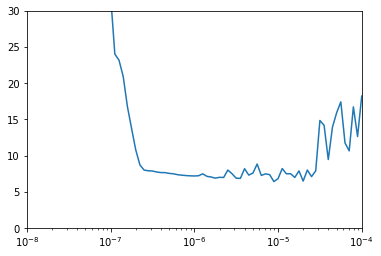

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=400, verbose=1)

Epoch 1/400
8/8 [==============================] - 1s 163ms/step - loss: 81.1157 - mae: 83.5783
Epoch 2/400
8/8 [==============================] - 0s 25ms/step - loss: 23.6081 - mae: 24.3853
Epoch 3/400
8/8 [==============================] - 0s 27ms/step - loss: 18.2198 - mae: 18.7074
Epoch 4/400
8/8 [==============================] - 0s 25ms/step - loss: 14.1505 - mae: 14.6784
Epoch 5/400
8/8 [==============================] - 0s 26ms/step - loss: 10.7213 - mae: 11.2667
Epoch 6/400
8/8 [==============================] - 0s 28ms/step - loss: 12.4218 - mae: 12.5794
Epoch 7/400
8/8 [==============================] - 0s 25ms/step - loss: 12.5426 - mae: 13.0905
Epoch 8/400
8/8 [==============================] - 0s 25ms/step - loss: 11.8619 - mae: 12.4402
Epoch 9/400
8/8 [==============================] - 0s 26ms/step - loss: 14.6098 - mae: 15.3259
Epoch 10/400
8/8 [==============================] - 0s 28ms/step - loss: 20.8749 - mae: 21.3485
Epoch 11/400
8/8 [==============================

8/8 [==============================] - 0s 28ms/step - loss: 4.7578 - mae: 5.2758
Epoch 88/400
8/8 [==============================] - 0s 26ms/step - loss: 5.2795 - mae: 5.7885
Epoch 89/400
8/8 [==============================] - 0s 24ms/step - loss: 5.7736 - mae: 6.2312
Epoch 90/400
8/8 [==============================] - 0s 25ms/step - loss: 6.1975 - mae: 6.6852
Epoch 91/400
8/8 [==============================] - 0s 28ms/step - loss: 6.5354 - mae: 7.0978
Epoch 92/400
8/8 [==============================] - 0s 25ms/step - loss: 7.6994 - mae: 8.2225
Epoch 93/400
8/8 [==============================] - 0s 25ms/step - loss: 7.6373 - mae: 8.1463
Epoch 94/400
8/8 [==============================] - 0s 26ms/step - loss: 5.9557 - mae: 6.4787
Epoch 95/400
8/8 [==============================] - 0s 26ms/step - loss: 5.7307 - mae: 6.1850
Epoch 96/400
8/8 [==============================] - 0s 25ms/step - loss: 6.2476 - mae: 6.7000
Epoch 97/400
8/8 [==============================] - 0s 25ms/step - loss: 

8/8 [==============================] - 0s 26ms/step - loss: 5.7602 - mae: 6.2592
Epoch 174/400
8/8 [==============================] - 0s 25ms/step - loss: 7.0239 - mae: 7.5446
Epoch 175/400
8/8 [==============================] - 0s 24ms/step - loss: 6.8651 - mae: 7.3238
Epoch 176/400
8/8 [==============================] - 0s 24ms/step - loss: 5.0622 - mae: 5.5571
Epoch 177/400
8/8 [==============================] - 0s 26ms/step - loss: 5.0644 - mae: 5.4602
Epoch 178/400
8/8 [==============================] - 0s 24ms/step - loss: 4.8372 - mae: 5.3450
Epoch 179/400
8/8 [==============================] - 0s 25ms/step - loss: 4.6989 - mae: 5.1652
Epoch 180/400
8/8 [==============================] - 0s 25ms/step - loss: 4.9221 - mae: 5.4363
Epoch 181/400
8/8 [==============================] - 0s 24ms/step - loss: 5.0033 - mae: 5.5392
Epoch 182/400
8/8 [==============================] - 0s 24ms/step - loss: 4.2731 - mae: 4.7511
Epoch 183/400
8/8 [==============================] - 0s 24ms/ste

8/8 [==============================] - 0s 24ms/step - loss: 4.3281 - mae: 4.8037
Epoch 260/400
8/8 [==============================] - 0s 25ms/step - loss: 4.5015 - mae: 4.9680
Epoch 261/400
8/8 [==============================] - 0s 24ms/step - loss: 4.6893 - mae: 5.1652
Epoch 262/400
8/8 [==============================] - 0s 24ms/step - loss: 6.4493 - mae: 6.9435
Epoch 263/400
8/8 [==============================] - 0s 24ms/step - loss: 5.9960 - mae: 6.4841
Epoch 264/400
8/8 [==============================] - 0s 26ms/step - loss: 4.8482 - mae: 5.3291
Epoch 265/400
8/8 [==============================] - 0s 27ms/step - loss: 4.8980 - mae: 5.3895
Epoch 266/400
8/8 [==============================] - 0s 25ms/step - loss: 5.3689 - mae: 5.8758
Epoch 267/400
8/8 [==============================] - 0s 25ms/step - loss: 4.6653 - mae: 5.1647
Epoch 268/400
8/8 [==============================] - 0s 29ms/step - loss: 4.1393 - mae: 4.6241
Epoch 269/400
8/8 [==============================] - 0s 25ms/ste

8/8 [==============================] - 0s 28ms/step - loss: 4.3556 - mae: 4.8164
Epoch 346/400
8/8 [==============================] - 0s 28ms/step - loss: 5.3325 - mae: 5.7753
Epoch 347/400
8/8 [==============================] - 0s 26ms/step - loss: 5.5469 - mae: 5.9885
Epoch 348/400
8/8 [==============================] - 0s 26ms/step - loss: 6.1892 - mae: 6.6412
Epoch 349/400
8/8 [==============================] - 0s 25ms/step - loss: 5.1830 - mae: 5.6268
Epoch 350/400
8/8 [==============================] - 0s 26ms/step - loss: 4.4858 - mae: 4.9881
Epoch 351/400
8/8 [==============================] - 0s 27ms/step - loss: 4.7489 - mae: 5.1828
Epoch 352/400
8/8 [==============================] - 0s 27ms/step - loss: 4.5824 - mae: 5.0626
Epoch 353/400
8/8 [==============================] - 0s 25ms/step - loss: 4.3032 - mae: 4.7837
Epoch 354/400
8/8 [==============================] - 0s 27ms/step - loss: 4.1144 - mae: 4.5667
Epoch 355/400
8/8 [==============================] - 0s 25ms/ste

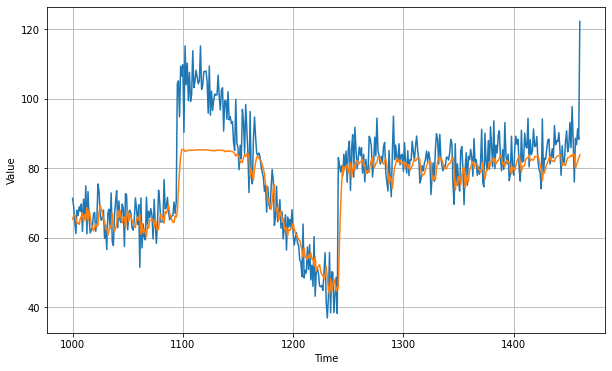

In [9]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.3731804

<Figure size 432x288 with 0 Axes>

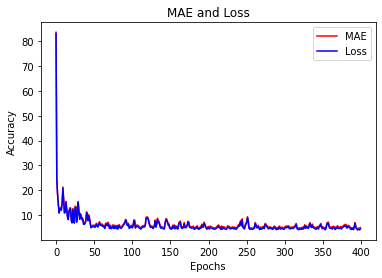

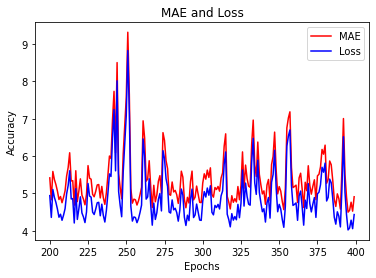

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()